In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Propagation of elastic waves in a 1D domain

\begin{align}
    \frac{\partial}{\partial x}
    \sigma( x, t ) {\color{red}+f(x,t)}
    & = 
    \rho( x ) \frac{\partial^2}{\partial t^2} 
    u( x, t )
    & \text{for }
    (x, t) \in \Omega \times (0, T)
    \\
    u( x_0, t ) & = U( t ) 
    & \text{for } t \in (0, T)
    \\
    u(x, t), & \, \sigma(x, t)
    &
    \Omega\text{-periodic} \\
    u(x, 0) & = u_0( x )
    & \text{for }
    x \in \Omega \\
    \frac{\partial}{\partial t} u(x, 0) & = v_0( x )
    & \text{for }
    x \in \Omega \\
    \sigma(x, t)
    & = 
    E( x ) \frac{\partial}{\partial x} u(x, t)
    & \text{for }    
    (x, t) \in \Omega \times (0, T)
\end{align}

In [4]:
func_rho = lambda x: 2700. # spatial distribution of density
func_E = lambda x: 70.3e9 # spatial distribution of Young’s modulus
func_u0 = lambda x: 0 * x # inital u_0
func_v0 = lambda x: 0 * x # initial derivation of u, periodical

def func_Ut(x0, t, L=2): # The perturbation as a prescribed displacement u(x_0, t) = U(t)
    A = 0.001
    alpha = 4
    c0 = np.sqrt(func_E(x0) / func_rho(x0))
    omega = 5 * np.pi * c0 / L
    if  t < np.pi/omega: 
        return A*(t * (np.pi/omega - t))**alpha / ((np.pi/omega)**2 / 4)**alpha
    else:
        return 0.

### Finite difference method

In [49]:
solutions_in_time = []

L = 2 # length of the domain in the spatial dimension x
T = 3.9919e-4 # length of the time frame
Nx = 157 # number of intervals in x
Nt = 239 # number of intervals in t
x = np.linspace(0, L, Nx+1)
dx = L / Nx
dt = T / Nt

# Newmark constants for the integration scheme
beta = 0.25 
gamma = 0.5

index_x0 = np.round(Nx/2).astype(int) # placing of the perturbation
x0 = np.zeros(Nx) # displacements on discretized spatial domain at t=0
x0[index_x0] = 1
Ft = np.zeros(Nt+1)

K = np.zeros((Nx, Nx))
D_rho = np.zeros(Nx)
D_E = np.zeros(Nx)
fd_mat = np.array([[-1, 1], [1, -1]])

for i in range(Nx):
    D_rho[i] = func_rho(x[i])
    D_E[i] = func_E(x[i])
    dE1 = func_E(i*dx - dx/2) / (2 * dx**2)
    dE2 = func_E(i*dx + dx/2) / (2 * dx**2)
    if i > 0:
        K[np.ix_(np.arange(i-1, i+1), np.arange(i-1, i+1))] += dE1 * fd_mat
    else:
        K[np.ix_([-1, 0], [-1, 0])] += dE1 * fd_mat
    if i < Nx-1:
        K[np.ix_(np.arange(i, i+2), np.arange(i, i+2))] += dE2 * fd_mat
    else:
        K[np.ix_([-1, 0], [-1, 0])] += dE2 * fd_mat

K_rho = -beta * dt**2 * K + np.diag(D_rho)
u0 = func_u0(x[:-1])
dt_u0 =  func_v0(x[:-1])
dtdt_u0 =  K @ u0
g0 = np.linalg.solve(K_rho, x0) # solution at t=0
g0_x0 = g0[index_x0]
t = 0
all_solutions = [g0]

for n in range(Nt):
    t += dt
    f = D_rho * (u0 + dt*dt_u0 + (dt**2)*(0.5 - beta)*dtdt_u0)
    un = np.linalg.solve(K_rho, f)
    Fn = (func_Ut(x0, t) - un[index_x0])/(beta * (dt**2) * g0_x0)
    un += beta * (dt**2)* g0 * Fn
    dtdt_un = 1/(beta * (dt**2)) * (un - u0 - dt*dt_u0 - (dt**2)*(0.5 - beta)*dtdt_u0)
    dt_un = dt_u0 + dt*(1 - gamma)*dtdt_u0 + dt * gamma * dtdt_un
    u0 = un
    dt_u0 = dt_un
    dtdt_u0 = dtdt_un
    Ft[n] = Fn
    all_solutions.append(un)

MovieWriter imagemagick unavailable; using Pillow instead.


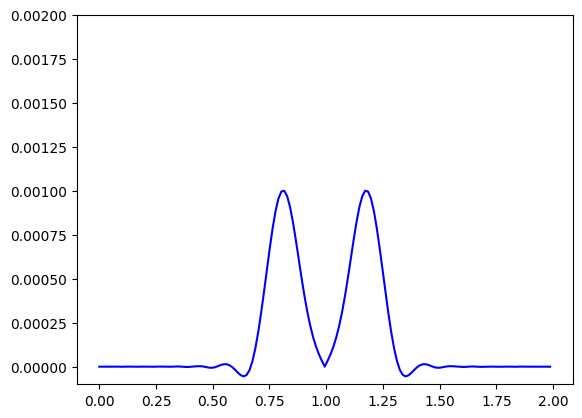

In [50]:
fig, ax = plt.subplots()
ln, = plt.plot(x[:-1], all_solutions[0], 'b')
ax.set_ylim([-0.0001, 0.002])

def update(frame):
    y = all_solutions[frame]
    ln.set_ydata(y)
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(Nt), blit=True)
ani.save('elastodynamics.gif', writer='Pillow')